## Image Inpainting with Image网

We'd like to make use of the [Image网 dataset](https://github.com/fastai/imagenette/blob/master/README.md). My understanding is that it doesn't have labels so it would make sense to use as a dataset for our pretext tasks

Once again our pretext task will be cutting patches out of images and having our neural network fill in the missing pieces. In this approach we use a U-Net and have the network generate the entire input image (including the pieces that are not missing).

In [16]:
import json
import torch

import numpy as np

from functools import partial

from fastai2.layers import MishJit, MaxPool
from fastai2.basics import DataBlock, RandomSplitter, GrandparentSplitter

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform, FlipItem
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from fastcore.utils import num_cpus

from torch.nn import MSELoss
from torchvision.models import resnet34

In [17]:
# NOTE: We use the data in /train 
images_path = untar_data(URLs.IMAGEWANG_160)

In [18]:
# We create this dummy class in order to create a transform that ONLY operates on images of this type
# We will use it to create all input images
class PILImageInput(PILImage): pass

class RandomCutout(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, min_n_holes=5, max_n_holes=10, min_length=5, max_length=50, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length
        

    def encodes(self, x:PILImageInput):
        """
        Note that we're accepting our dummy PILImageInput class
        fastai2 will only pass images of this type to our encoder. 
        This means that our transform will only be applied to input images and won't
        be run against output images.
        """
        
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
        pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        h,w = pixels.shape[:2]

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            pixels[y1:y2, x1:x2, :] = 0
            
        return Image.fromarray(pixels, mode='RGB')

We will train this network with the best hyper-parameters/optimizer/settings we know. These settings come from [training Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf). 

One thing to keep in mind is that the above is a classification task, so it's not 100% guaranteed that these settings will map perfectly to our task. That said, they're probably a very good starting point.

As of January 2020 the [best parameters](https://github.com/fastai/imagenette/blob/58a63175a2c6457650289d32741940d6a7d58fbf/2020-01-train.md) are:

```
--lr 8e-3 
--sqrmom 0.99 
--mom 0.95 
--eps 1e-6 
--bs 64 
--opt ranger 
--sa 1
--fp16 1 
--arch xse_resnext50 
--pool MaxPool
```

One change we're making is that we're going to use **`xresnet50`** here. At least in part because I'm not familiar with `xse_resnext50`.

In [19]:
# Default parameters
gpu=None
lr=1e-2
size=128
sqrmom=0.99
mom=0.9
eps=1e-6
epochs=15
bs=64
mixup=0.
opt='ranger',
arch='xresnet50'
sh=0.
sa=0
sym=0
beta=0.
act_fn='MishJit'
fp16=0
pool='AvgPool',
dump=0
runs=1
meta=''

In [20]:
#TODO: Use xse-resnext50
from fastai2.vision.models.xresnet import xresnet50, xresnet34

# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1                 #NOTE: NOT USED HERE. Do we need this?
fp16=0               #NOTE: My GPU cannot run fp16 :'(
arch='xresnet50' 
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
m = xresnet34
act_fn = MishJit
pool = MaxPool

In [21]:
data = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [22]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    #CHANGE: Input is ImageBlock(cls=PILImageInput)
    #CHANGE: Output is ImageBlock
    #CHANGE: Splitter is RandomSplitter (instead of on /val folder)
    
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, 
                       get_y=lambda o: o)
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5), RandomCutout]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    return dblock.databunch(source, path=source, bs=bs, num_workers=workers,
                            item_tfms=item_tfms, batch_tfms=batch_tfms)

In [23]:
if gpu is not None: torch.cuda.set_device(gpu)
if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [24]:
size = 160
#CHANGE: I can only fit ~32 images in a batch
bs = 32

dbunch = get_dbunch(size, bs, sh=sh)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']
if not gpu: print(f'lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')

lr: 0.008; size: 160; sqrmom: 0.99; mom: 0.95; eps: 1e-06


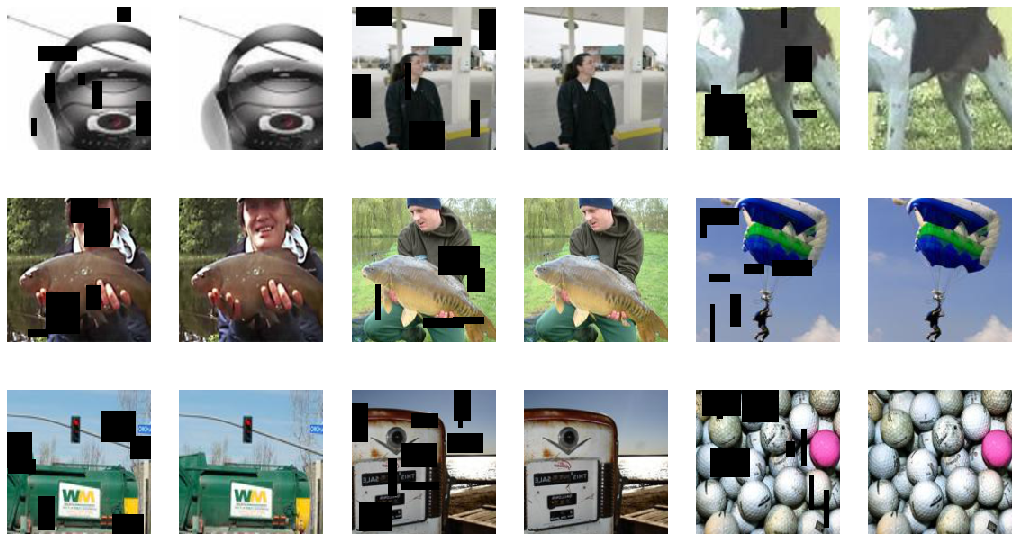

In [25]:
dbunch.show_batch()

In [26]:
for run in range(runs):
        print(f'Run: {run}')
        #NOTE: We are using MSELoss and vanilla xresnet50
        learn = unet_learner(dbunch, m, opt_func=opt_func, metrics=[], loss_func=MSELoss())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        #n_gpu = torch.cuda.device_count()
        #if gpu is None and n_gpu: learn.to_parallel()
        #if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,time
0,0.007711,0.002942,02:43
1,0.004188,0.002705,02:35
2,0.003794,0.002375,02:34
3,0.003686,0.002531,02:33
4,0.003430,0.002283,02:34
5,0.003448,0.002111,02:34
6,0.003354,0.002145,02:34
7,0.003397,0.002155,02:34
8,0.003264,0.002081,02:34
9,0.003391,0.002065,02:34


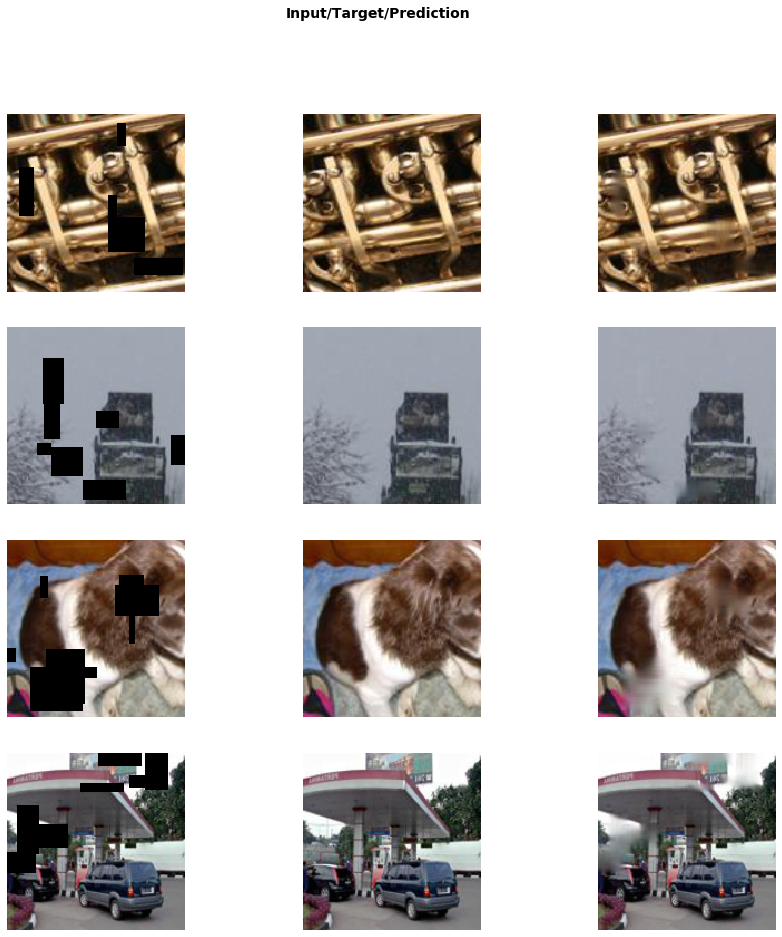

In [27]:
# Let's take a look at the output images
learn.predict(dbunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

In [29]:
# I'm not using fastai2's .export() because I only want to save 
# the model's parameters. 
torch.save(learn.model[0].state_dict(), 'imagewang_inpainting_15_epochs.pth')

Note: This approach seems to work reasonably well, but the outputs are noticably blurry. 

This [paper](https://arxiv.org/pdf/1604.07379.pdf) notes that and instead uses a combined L2 loss + adversarial loss to generate more realistic images. That said, I'm not sure if more realistic images necessarily translates into better downstream performance. For that reason, I'm not quite sure if I'd like to go down the GAN route just yet.